Part 2 - Q2 - Representation Learning
===



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tsfresh as tsf
from tsfresh import extract_features
import warnings

In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

2024-05-20 14:39:56.653056: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 14:39:57.726032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 14:40:03.812858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
format_dict = par.create_format_dict()

In [7]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [8]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/mitbih_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/mitbih_train.csv', header=None)

In [9]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_heart_train.shape

(87554, 188)

In [11]:
df_heart_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
      dtype='int64', length=188)

In [12]:
n_train_examples = df_heart_train.shape[0]
n_test_examples = df_heart_test.shape[0]
n_total_examples = n_train_examples + n_test_examples
print(f'The test split has {n_test_examples} rows, or {n_test_examples/n_total_examples:.2%} of all examples (which represent {n_total_examples} rows).')

The test split has 21892 rows, or 20.00% of all examples (which represent 109446 rows).


## Labels

In [13]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
n_classes = len(labels_count.columns)
labels_count.style.format(format_dict)

,0.0,4.0,2.0,1.0,3.0
proportion,83%,7%,7%,3%,1%


/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


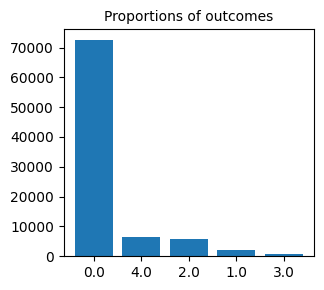

In [14]:
gr.dist_mult_plots(
    df_heart_train,
    cols=[label_col],
		rename_cols_for_title={label_col: 'Proportions of outcomes'},
    figsize=(6, 3),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
)

In [66]:
x_train_0, x_test_0, y_train_0, y_test_0 = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
)

# Q2-1: Pretrain an encoder

Pretrain an encoder using the objective of your choice on the training set of the MIT-BIH dataset

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

I use `n_neurons = 40` in the last Dense layer of the encoder, to match the dimension of the encoder of question 1. 

Remember the architecture of encoder 1, before the activation head, with the parameter `n_neurons = 120`:

> 		model.add(Dense(n_neurons, activation='relu', input_shape=(input_dim,)))
> 		model.add(Dropout(final_dropout))
> 		model.add(Dense(int(2*n_neurons/3), activation='relu', input_shape=(input_dim,)))
> 		model.add(Dropout(final_dropout))
> 		model.add(Dense(int(n_neurons/3), activation='relu', input_shape=(input_dim,)))

As the last (non-activation) layer has a dimension of `int(n_neurons/3)`, we are getting the same dimension of `40` in both encoders.



In [132]:
n_neurons = 40

num_samples = x_train_0.shape[0]

x_train_0_subset = x_train_0[:num_samples, :]
y_train_0_subset = y_train_0[:num_samples, :]

seq_length = x_train_0_subset.shape[1]
input_dim = 1
num_classes = n_classes

x_train_0_subset = x_train_0_subset.reshape(num_samples, seq_length, input_dim)

In [133]:
# Step 1: Data Preparation
def generate_pairs(data, augment_fn, batch_size=32):
    while True:
        idx = np.random.choice(len(data), batch_size, replace=False)
        x1 = data[idx]
        x2 = augment_fn(x1)
        yield x1, x2

def augment_fn(x):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.1)
    return x + noise

# Step 2: Define the Encoder Model
def create_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)

		# This is where the dimension of the pre-training representation is decided, with `n_neurons`
    outputs = layers.Dense(n_neurons, activation=None)(x)
    model = models.Model(inputs, outputs)
    return model

# Step 3: Define the InfoNCE Loss Function
def contrastive_loss(z_i, z_j, temperature=0.1):
    batch_size = tf.shape(z_i)[0]
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)
    similarity_matrix = tf.matmul(z_i, z_j, transpose_b=True) / temperature
    labels = tf.range(batch_size)
    loss_i = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, similarity_matrix)
    loss_j = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, tf.transpose(similarity_matrix))
    loss = tf.reduce_mean(loss_i + loss_j)
    return loss

# Step 4: Pre-Training with InfoNCE
input_shape = (seq_length, input_dim)
encoder = create_encoder(input_shape)
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x1, x2):
    with tf.GradientTape() as tape:
        z_i = encoder(x1, training=True)
        z_j = encoder(x2, training=True)
        loss = contrastive_loss(z_i, z_j)
    gradients = tape.gradient(loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
    return loss

batch_size = 32
epochs = 10
steps_per_epoch = num_samples // batch_size

loss_curve = []

for epoch in range(epochs):
		for step in range(steps_per_epoch):
				x1, x2 = next(generate_pairs(x_train_0_subset, augment_fn, batch_size))
				loss = train_step(x1, x2)
				if step % 100 == 0:
						print(f"Epoch {epoch + 1}, Step {step}, Loss: {loss.numpy()}")
						loss_curve.append(loss)

Epoch 1, Step 0, Loss: 6.911179542541504


Epoch 1, Step 100, Loss: 2.559769868850708
Epoch 1, Step 200, Loss: 2.044443130493164
Epoch 1, Step 300, Loss: 2.143240451812744
Epoch 1, Step 400, Loss: 1.551101803779602
Epoch 1, Step 500, Loss: 1.2090952396392822
Epoch 1, Step 600, Loss: 1.4321403503417969
Epoch 1, Step 700, Loss: 1.0921266078948975
Epoch 1, Step 800, Loss: 0.970098614692688
Epoch 1, Step 900, Loss: 0.8524487018585205
Epoch 1, Step 1000, Loss: 0.5631124377250671
Epoch 1, Step 1100, Loss: 0.6899664402008057
Epoch 1, Step 1200, Loss: 0.6819719076156616
Epoch 1, Step 1300, Loss: 0.7431716322898865
Epoch 1, Step 1400, Loss: 1.0783255100250244
Epoch 1, Step 1500, Loss: 0.5640213489532471
Epoch 1, Step 1600, Loss: 0.697827935218811
Epoch 1, Step 1700, Loss: 0.5284583568572998
Epoch 1, Step 1800, Loss: 0.7741290926933289
Epoch 1, Step 1900, Loss: 0.41358619928359985
Epoch 1, Step 2000, Loss: 0.48721015453338623
Epoch 1, Step 2100, Loss: 0.5036612749099731
Epoch 2, Step 0, Loss: 0.5537932515144348
Epoch 2, Step 100, Loss: 0

Text(0, 0.5, 'loss')

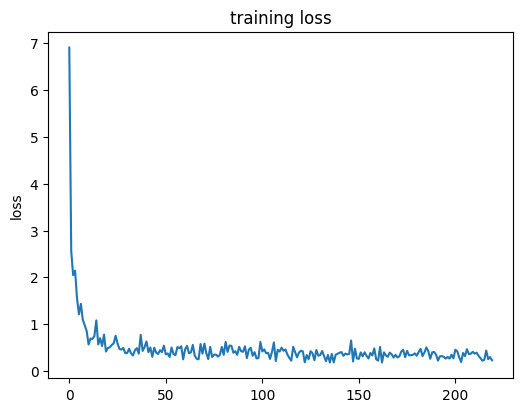

In [134]:
fig, axes = plt.subplots(1, 1, figsize = (6,4.5))
axes.plot(loss_curve)
# axes[0].plot(history.history['val_accuracy'],'--')
axes.set_title('training loss')
axes.set_ylabel('loss')

In [136]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
encoder.save("encoder_2.h5")
encoder.save('encoder_2.keras')
print("Saved model to disk")

Saved model to disk


# Q2-2: Pretraining Evaluation on MIT-BIH

Evaluation of the Pretraining: train a classic ML method from Part 1 to predict the MIT-BIH labels from the learned representations of the training set and evaluate the representation learning quality on the test set of the MIT-BIH dataset

In [163]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.optimizers import Adam

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        
        return K.mean(fl)
    return focal_loss_fixed

In [160]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [191]:
learning_rate=0.01
use_focal=True
clipnorm=0.5
use_sgd_opt=False,
use_rms_opt=False,

In [193]:
# Step 5: Fine-Tuning with Supervised Learning
# Use the learned encoder and add a classification head
encoded_inputs = layers.Input(shape=(n_neurons,))
classification_output = layers.Dense(num_classes, activation='softmax')(encoded_inputs)
classification_model = models.Model(encoded_inputs, classification_output)

# Freeze the encoder weights and create a full model
encoder.trainable = False
full_input = layers.Input(shape=(seq_length, input_dim))
encoded_output = encoder(full_input)
classification_output = classification_model(encoded_output)
full_model = models.Model(full_input, classification_output)

# Compile and train the full model with labels
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	full_model.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = full_model.fit(
	x_train_0_subset,
	y_train_0_subset,
	batch_size=batch_size,
	epochs=8,
	validation_data=(x_test_0, y_test_0),
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
 242/2189 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.4991 - loss: 0.0557

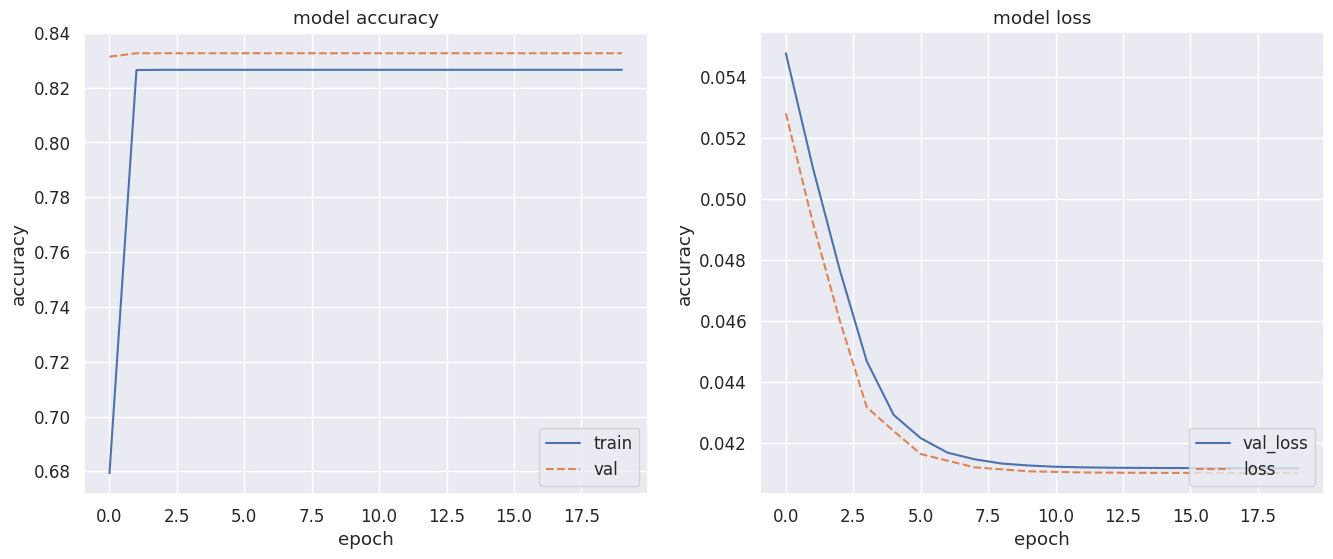

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

## Evaluation

In [ ]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [ ]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

In [ ]:
y_pred_proba = full_model.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


In [ ]:
y_pred_class_df.value_counts()

0    21892
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,82.8%,20.0%,18.1%


In [ ]:
classes_correspondances = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
classes_correspondances_inverted = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}
list_for_graph_labels = []
for i in range(5):
	list_for_graph_labels.append(str(i) + f": '{classes_correspondances_inverted[i]}'")
list_for_graph_labels

["0: 'N'", "1: 'S'", "2: 'V'", "3: 'F'", "4: 'Q'"]

Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

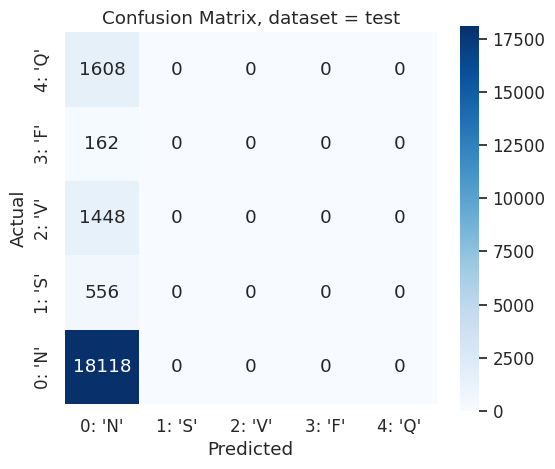

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=list_for_graph_labels,
    yticklabels=list_for_graph_labels)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
# ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [ ]:
# # equivalent to: model.save("model.h5")
# from tensorflow.keras.models import save_model
# # save_model(model, "model_second_save.h5")
# # save model and architecture to single file
# model_log.save("model_log.h5")
# model_log.save('model_log.keras')
# print("Saved model to disk")

Saved model to disk
